<a href="https://colab.research.google.com/github/joselcadavid/LSTM-EEG/blob/main/03_modelo_CTR_DCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, cohen_kappa_score,
                            balanced_accuracy_score, accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout,
                                     BatchNormalization, GaussianNoise)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2


In [ ]:
# =============================================================================
# CONFIGURACIÓN OPTIMIZADA
# =============================================================================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# CRÍTICO: Secuencias más largas y mayor overlap para datasets pequeños
SEQ_LENGTH = 20      # Más contexto temporal
STRIDE = 2           # Mucho overlap = más ejemplos de entrenamiento
USE_AUGMENTATION = True
N_AUGMENTATIONS = 3  # Multiplicar datos por N

In [ ]:
# =============================================================================
# 1. CARGAR DATOS
# =============================================================================
path = "https://raw.githubusercontent.com/joselcadavid/Datos-EEG/b1e42aed7c72cbad3d65f252ffc22be7776f9fc5/EEG_WELCH_PermEntropy_por_banda.csv"
df = pd.read_csv(path, sep=";")

meta_cols = ["subject", "diagnosis", "window_index", "start_time_s", "end_time_s"]
feature_cols = [c for c in df.columns if c not in meta_cols]

print(f"Features: {len(feature_cols)}")
print(f"Ventanas totales: {len(df)}")

# Verificar si hay NaN
if df[feature_cols].isnull().any().any():
    print("⚠ Advertencia: Hay valores NaN. Rellenando con mediana...")
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

df = df[df["diagnosis"].isin(["CTR", "DCL"])].copy()
subjects_df = df[["subject", "diagnosis"]].drop_duplicates().reset_index(drop=True)
print(f"Sujetos: {len(subjects_df)}")
print(f"\nDistribución diagnósticos:\n{subjects_df['diagnosis'].value_counts()}")


Features: 128
Ventanas totales: 5724
Sujetos: 56

Distribución diagnósticos:
diagnosis
CTR    38
DCL    18
Name: count, dtype: int64


In [ ]:
# =============================================================================
# 2. SPLIT ESTRATIFICADO
# =============================================================================
test_frac = 0.3
rng = np.random.default_rng(RANDOM_SEED)

train_subjects = []
test_subjects = []

print("\nDivisión train/test:")
for diag, group in subjects_df.groupby("diagnosis"):
    subs = group["subject"].values.copy()
    rng.shuffle(subs)
    n_test = max(1, int(round(len(subs) * test_frac)))
    test_subjects.extend(subs[:n_test])
    train_subjects.extend(subs[n_test:])
    print(f"  {diag}: train={len(subs[n_test:])}, test={n_test}")


División train/test:
  CTR: train=27, test=11
  DCL: train=13, test=5


In [ ]:
# =============================================================================
# 3. DATA AUGMENTATION FUNCTIONS
# =============================================================================
def add_noise(X, noise_level=0.02):
    """Añade ruido gaussiano"""
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

def scale_data(X, scale_factor=0.1):
    """Escala los datos ligeramente"""
    scale = 1 + np.random.uniform(-scale_factor, scale_factor, (X.shape[0], 1, 1))
    return X * scale

def shift_data(X, shift_max=2):
    """Desplaza temporalmente (circular shift)"""
    shift = np.random.randint(-shift_max, shift_max+1)
    return np.roll(X, shift, axis=1)

def time_warp(X, sigma=0.2):
    """Time warping suave"""
    seq_len = X.shape[1]
    n_features = X.shape[2]

    # Crear warping smoothe
    warp = np.cumsum(np.random.normal(1.0, sigma, seq_len))
    warp = warp / warp[-1] * (seq_len - 1)

    X_warped = np.zeros_like(X)
    for i in range(X.shape[0]):
        for f in range(n_features):
            X_warped[i, :, f] = np.interp(
                np.arange(seq_len),
                warp,
                X[i, :, f]
            )
    return X_warped

def augment_data(X, y, n_augmentations=2):
    """Aplica múltiples técnicas de augmentation"""
    X_aug_list = [X]
    y_aug_list = [y]

    for _ in range(n_augmentations):
        # Elegir aleatoriamente qué augmentation aplicar
        aug_choice = np.random.randint(0, 4)

        if aug_choice == 0:
            X_new = add_noise(X, noise_level=np.random.uniform(0.01, 0.03))
        elif aug_choice == 1:
            X_new = scale_data(X, scale_factor=np.random.uniform(0.05, 0.15))
        elif aug_choice == 2:
            X_new = shift_data(X, shift_max=3)
        else:
            X_new = time_warp(X, sigma=np.random.uniform(0.1, 0.3))

        X_aug_list.append(X_new)
        y_aug_list.append(y)

    return np.concatenate(X_aug_list), np.concatenate(y_aug_list)

In [ ]:
# =============================================================================
# 4. CREAR SECUENCIAS CON SLIDING WINDOW
# =============================================================================
def create_sequences(df, subject_list, feature_cols, scaler, seq_length,
                    stride, fit_scaler=False):
    """Crea secuencias con sliding window agresivo"""
    X_sequences = []
    y_sequences = []
    subject_ids = []

    for subj in subject_list:
        subj_data = df[df["subject"] == subj].sort_values("window_index")
        features = subj_data[feature_cols].values
        label = subj_data["diagnosis"].iloc[0]

        if fit_scaler:
            scaler.partial_fit(features)

        # Escalar
        features_scaled = scaler.transform(features).astype("float32")
        n_windows = len(features_scaled)

        # Sliding window con stride pequeño (más overlap = más datos)
        for start_idx in range(0, max(1, n_windows - seq_length + 1), stride):
            end_idx = start_idx + seq_length
            if end_idx <= n_windows:
                sequence = features_scaled[start_idx:end_idx]
                X_sequences.append(sequence)
                y_sequences.append(label)
                subject_ids.append(subj)

    if len(X_sequences) == 0:
        raise ValueError(f"No se pudieron crear secuencias. Verifica SEQ_LENGTH={seq_length}")

    return np.array(X_sequences), np.array(y_sequences), np.array(subject_ids)

In [ ]:
# =============================================================================
# 5. PREPARAR DATOS
# =============================================================================
print(f"\n{'='*80}")
print("PREPARANDO SECUENCIAS")
print(f"{'='*80}")

scaler = RobustScaler()
train_windows = df[df["subject"].isin(train_subjects)]
scaler.fit(train_windows[feature_cols])

print(f"SEQ_LENGTH={SEQ_LENGTH}, STRIDE={STRIDE}")

# Crear secuencias
X_train, y_train, train_seq_subjects = create_sequences(
    df, train_subjects, feature_cols, scaler, SEQ_LENGTH, STRIDE
)
X_test, y_test, test_seq_subjects = create_sequences(
    df, test_subjects, feature_cols, scaler, SEQ_LENGTH, STRIDE
)

print(f"\nSecuencias originales:")
print(f"  Train: {X_train.shape[0]}")
print(f"  Test: {X_test.shape[0]}")

# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)
n_features = X_train.shape[2]

print(f"\nClases: {le.classes_}")
print(f"Distribución train: {Counter(y_train_enc)}")
print(f"Distribución test: {Counter(y_test_enc)}")


PREPARANDO SECUENCIAS
SEQ_LENGTH=20, STRIDE=2

Secuencias originales:
  Train: 561
  Test: 217

Clases: ['CTR' 'DCL']
Distribución train: Counter({np.int64(0): 374, np.int64(1): 187})
Distribución test: Counter({np.int64(0): 146, np.int64(1): 71})


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

In [ ]:
# =============================================================================
# 6. DATA AUGMENTATION
# =============================================================================
if USE_AUGMENTATION:
    print(f"\n{'='*80}")
    print(f"APLICANDO DATA AUGMENTATION (x{N_AUGMENTATIONS})")
    print(f"{'='*80}")

    X_train, y_train_enc = augment_data(X_train, y_train_enc, N_AUGMENTATIONS)

    print(f"Secuencias después de augmentation: {X_train.shape[0]}")
    print(f"Nueva distribución: {Counter(y_train_enc)}")


APLICANDO DATA AUGMENTATION (x3)
Secuencias después de augmentation: 2244
Nueva distribución: Counter({np.int64(0): 1496, np.int64(1): 748})


In [ ]:
# =============================================================================
# 7. MODELO
# =============================================================================
def create_simple_lstm(seq_length, n_features, num_classes):
    """
    Modelo LSTM SIMPLE para datasets pequeños:
    - Menos parámetros = menos overfitting
    - Más regularización
    - GaussianNoise layer para robustez
    """
    inputs = Input(shape=(seq_length, n_features))

    # Añadir ruido durante entrenamiento (regularización implícita)
    x = GaussianNoise(0.01)(inputs)

    # LSTM simple con regularización L1+L2
    x = LSTM(32,
             return_sequences=False,
             recurrent_dropout=0.3,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)

    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Capa densa intermedia pequeña
    x = Dense(16, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(0.4)(x)

    # Salida
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs=inputs, outputs=outputs, name="Simple_LSTM")


In [ ]:
# =============================================================================
# 8. CREAR Y COMPILAR MODELO
# =============================================================================
print(f"\n{'='*80}")
print("CREANDO MODELO")
print(f"{'='*80}")

model = create_simple_lstm(SEQ_LENGTH, n_features, num_classes)

# Usar learning rate más bajo
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  # LR más bajo
    metrics=["accuracy"]
)

model.summary()


CREANDO MODELO


Model: "Simple_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,298 (83.20 KB)

 Trainable params: 21,234 (82.95 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# =============================================================================
# 9. CALLBACKS
# =============================================================================
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,  # Más paciencia
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Class weights más agresivos
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
# Amplificar los pesos
class_weights = {i: w * 1.5 for i, w in enumerate(class_weights)}
print(f"\nClass weights: {class_weights}")


Class weights: {0: np.float64(1.125), 1: np.float64(2.25)}


In [ ]:
# =============================================================================
# 10. ENTRENAMIENTO
# =============================================================================
print(f"\n{'='*80}")
print("ENTRENAMIENTO")
print(f"{'='*80}")

history = model.fit(
    X_train, y_train_enc,
    validation_split=0.15,  # Menos validación, más datos para train
    epochs=150,
    batch_size=32,  # Batch más grande para estabilidad
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


ENTRENAMIENTO
Epoch 1/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5642 - loss: 1.3448 - val_accuracy: 0.9169 - val_loss: 0.6021 - learning_rate: 5.0000e-04
Epoch 2/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7119 - loss: 0.8818 - val_accuracy: 0.9614 - val_loss: 0.4482 - learning_rate: 5.0000e-04
Epoch 3/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7929 - loss: 0.6823 - val_accuracy: 0.9733 - val_loss: 0.3268 - learning_rate: 5.0000e-04
Epoch 4/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8307 - loss: 0.5725 - val_accuracy: 0.9822 - val_loss: 0.2281 - learning_rate: 5.0000e-04
Epoch 5/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8751 - loss: 0.4794 - val_accuracy: 0.9911 - val_loss: 0.1555 - learning_rate: 5.0000e-04
Epoch 6/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8990 - loss: 0.3850 - val_accuracy: 1.0000 - val_loss: 0.1053 - learning_rate: 5.0000e-04
Epoch 7/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/st

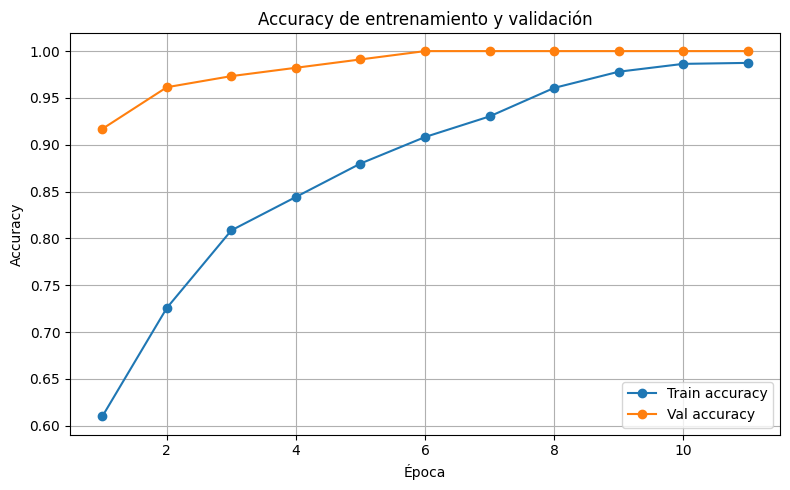

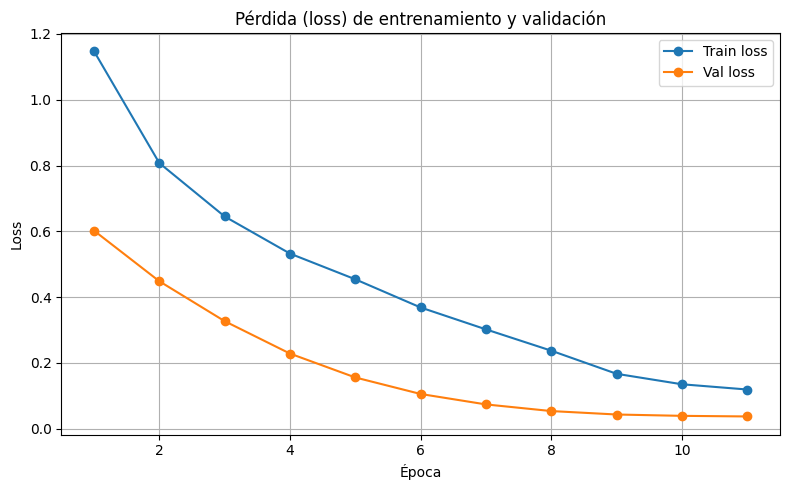

In [ ]:
import matplotlib.pyplot as plt

# ===============================
# GRÁFICAS DE ENTRENAMIENTO
# ===============================

hist = history.history

# Eje x: número de época empezando en 1
epochs = range(1, len(hist["loss"]) + 1)

# 1) Accuracy train / val (puntos + líneas)
plt.figure(figsize=(8, 5))
plt.plot(epochs, hist["accuracy"], marker="o", linestyle="-", label="Train accuracy")
plt.plot(epochs, hist["val_accuracy"], marker="o", linestyle="-", label="Val accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy de entrenamiento y validación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_accuracy.png", dpi=150)
plt.show()

# 2) Loss train / val (puntos + líneas)
plt.figure(figsize=(8, 5))
plt.plot(epochs, hist["loss"], marker="o", linestyle="-", label="Train loss")
plt.plot(epochs, hist["val_loss"], marker="o", linestyle="-", label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida (loss) de entrenamiento y validación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_loss.png", dpi=150)
plt.show()


In [ ]:
# =============================================================================
# 11. EVALUACIÓN POR SECUENCIAS
# =============================================================================
print(f"\n{'='*80}")
print("EVALUACIÓN POR SECUENCIAS")
print(f"{'='*80}")

y_pred_proba = model.predict(X_test, verbose=0)
y_pred = y_pred_proba.argmax(axis=1)

seq_acc = balanced_accuracy_score(y_test_enc, y_pred)
print(f"\nBalanced Accuracy (secuencias): {seq_acc:.4f}")

print("\nMatriz de confusión (secuencias):")
cm = confusion_matrix(y_test_enc, y_pred)
print(cm)

# Normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nMatriz normalizada (% por fila):")
for i, row in enumerate(cm_norm):
    print(f"{le.classes_[i]:5s}: " + " ".join([f"{x:5.1%}" for x in row]))

print("\nReporte de clasificación (secuencias):")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_,
                          zero_division=0))


EVALUACIÓN POR SECUENCIAS

Balanced Accuracy (secuencias): 0.6523

Matriz de confusión (secuencias):
[[100  46]
 [ 27  44]]

Matriz normalizada (% por fila):
CTR  : 68.5% 31.5%
DCL  : 38.0% 62.0%

Reporte de clasificación (secuencias):
              precision    recall  f1-score   support

         CTR       0.79      0.68      0.73       146
         DCL       0.49      0.62      0.55        71

    accuracy                           0.66       217
   macro avg       0.64      0.65      0.64       217
weighted avg       0.69      0.66      0.67       217



In [ ]:
# =============================================================================
# 12. EVALUACIÓN POR SUJETO (VOTACIÓN MAYORITARIA)
# =============================================================================
print(f"\n{'='*80}")
print("EVALUACIÓN POR SUJETO (Votación Mayoritaria)")
print(f"{'='*80}")

# Agrupar por sujeto
subject_votes = defaultdict(list)
subject_true_labels = {}

for i, subj in enumerate(test_seq_subjects):
    pred_class = y_pred[i]
    subject_votes[subj].append(pred_class)
    subject_true_labels[subj] = y_test_enc[i]

# Predicción por votación mayoritaria
y_true_subjects = []
y_pred_subjects = []

for subj in subject_votes.keys():
    # Votación mayoritaria
    votes = subject_votes[subj]
    pred_class = Counter(votes).most_common(1)[0][0]

    y_true_subjects.append(subject_true_labels[subj])
    y_pred_subjects.append(pred_class)

y_true_subjects = np.array(y_true_subjects)
y_pred_subjects = np.array(y_pred_subjects)

subj_acc = accuracy_score(y_true_subjects, y_pred_subjects)
subj_bal_acc = balanced_accuracy_score(y_true_subjects, y_pred_subjects)
kappa = cohen_kappa_score(y_true_subjects, y_pred_subjects)

print(f"\nAccuracy (sujetos): {subj_acc:.4f}")
print(f"Balanced Accuracy (sujetos): {subj_bal_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nMatriz de confusión (sujetos):")
cm_subj = confusion_matrix(y_true_subjects, y_pred_subjects)
print(cm_subj)

# Normalizada
cm_subj_norm = cm_subj.astype('float') / cm_subj.sum(axis=1)[:, np.newaxis]
print("\nMatriz normalizada (% por fila):")
for i, row in enumerate(cm_subj_norm):
    print(f"{le.classes_[i]:5s}: " + " ".join([f"{x:5.1%}" for x in row]))

print("\nReporte de clasificación (sujetos):")
print(classification_report(y_true_subjects, y_pred_subjects,
                          target_names=le.classes_, zero_division=0))


EVALUACIÓN POR SUJETO (Votación Mayoritaria)

Accuracy (sujetos): 0.6875
Balanced Accuracy (sujetos): 0.6636
Cohen's Kappa: 0.3103

Matriz de confusión (sujetos):
[[8 3]
 [2 3]]

Matriz normalizada (% por fila):
CTR  : 72.7% 27.3%
DCL  : 40.0% 60.0%

Reporte de clasificación (sujetos):
              precision    recall  f1-score   support

         CTR       0.80      0.73      0.76        11
         DCL       0.50      0.60      0.55         5

    accuracy                           0.69        16
   macro avg       0.65      0.66      0.65        16
weighted avg       0.71      0.69      0.69        16



In [ ]:
# =============================================================================
# 13. ANÁLISIS DE CONFIANZA
# =============================================================================
print(f"\n{'='*80}")
print("ANÁLISIS DE CONFIANZA DE PREDICCIONES")
print(f"{'='*80}")

# Agrupar probabilidades por sujeto
subject_probas = defaultdict(list)
for i, subj in enumerate(test_seq_subjects):
    subject_probas[subj].append(y_pred_proba[i])

print("\nConfianza promedio por sujeto:")
for subj in sorted(subject_probas.keys()):
    mean_proba = np.mean(subject_probas[subj], axis=0)
    max_conf = mean_proba.max()
    pred_class = le.classes_[mean_proba.argmax()]
    true_class = le.classes_[subject_true_labels[subj]]
    correct = "✓" if pred_class == true_class else "✗"

    print(f"  {subj}: pred={pred_class:5s} (conf={max_conf:.2f}) | "
          f"true={true_class:5s} {correct}")


ANÁLISIS DE CONFIANZA DE PREDICCIONES

Confianza promedio por sujeto:
  sub-CTR005: pred=CTR   (conf=0.60) | true=CTR   ✓
  sub-CTR006: pred=CTR   (conf=0.91) | true=CTR   ✓
  sub-CTR008: pred=DCL   (conf=0.52) | true=CTR   ✗
  sub-CTR019: pred=CTR   (conf=0.99) | true=CTR   ✓
  sub-CTR023: pred=CTR   (conf=0.61) | true=CTR   ✓
  sub-CTR025: pred=CTR   (conf=0.51) | true=CTR   ✓
  sub-CTR028: pred=CTR   (conf=0.67) | true=CTR   ✓
  sub-CTR029: pred=DCL   (conf=0.76) | true=CTR   ✗
  sub-CTR030: pred=CTR   (conf=0.67) | true=CTR   ✓
  sub-CTR035: pred=CTR   (conf=0.90) | true=CTR   ✓
  sub-CTR038: pred=CTR   (conf=0.69) | true=CTR   ✓
  sub-DCL003: pred=DCL   (conf=0.94) | true=DCL   ✓
  sub-DCL007: pred=DCL   (conf=0.70) | true=DCL   ✓
  sub-DCL010: pred=CTR   (conf=0.86) | true=DCL   ✗
  sub-DCL014: pred=CTR   (conf=0.90) | true=DCL   ✗
  sub-DCL020: pred=DCL   (conf=0.84) | true=DCL   ✓
